In [1]:
# ============================================================================
# SBERT ENCODING - NOTEBOOK DE DÉVELOPPEMENT
# ============================================================================

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import faiss
import pickle
import time
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Imports réussis")

/Users/capo/Desktop/JobMatch/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


✅ Imports réussis


In [2]:
# Charger le dataset préparé
df = pd.read_csv('../data/processed/healthcare_jobs_sample_2000.csv')

print(f"📊 Dataset chargé : {len(df):,} offres")
print(f"📝 Colonnes : {list(df.columns)}")

# Préparer le texte pour SBERT
df['text_for_sbert'] = df['title'] + " | " + df['description'].astype(str)

# Statistiques
text_lengths = df['text_for_sbert'].str.split().str.len()
print(f"\n📊 Longueur moyenne : {text_lengths.mean():.0f} mots")
print(f"   > 400 mots : {(text_lengths > 400).sum()} ({(text_lengths > 400).sum()/len(df)*100:.1f}%)")

# Afficher 3 exemples
print(f"\n📋 EXEMPLES :")
for i in range(3):
    print(f"\n{i+1}. {df.iloc[i]['title']}")
    print(f"   {df.iloc[i]['text_for_sbert'][:150]}...")

📊 Dataset chargé : 1,998 offres
📝 Colonnes : ['job_id', 'title', 'description', 'location', 'formatted_experience_level', 'skill_name', 'confidence_level']

📊 Longueur moyenne : 502 mots
   > 400 mots : 1155 (57.8%)

📋 EXEMPLES :

1. Registered Nurse - Medical / Surgical
   Registered Nurse - Medical / Surgical | Details: Must Have 2+ Years of recent Medical-Surgical experience.

Specialty: Medical-Surgical Discipline: Re...

2. Patient Care Representative
   Patient Care Representative | As a healthcare Patient Care Representative in our Communication Center you will be responsible for successfully managin...

3. OR Travel RN - Job Id: JO03721634
   OR Travel RN - Job Id: JO03721634 | Health Carousel Nursing and Allied Health is seeking RN for an assignment in Austell, GA starting 4/19/2024, Shift...


In [4]:
print("🤖 Chargement du modèle SBERT...")
start = time.time()

model = SentenceTransformer('all-MiniLM-L6-v2')

print(f"✅ Modèle chargé en {time.time() - start:.2f}s")

# TEST RAPIDE AMÉLIORÉ (phrases complètes)
test_texts = [
    "Looking for an experienced Registered Nurse to work in our Emergency Department with critical care patients",
    "We are hiring a Physical Therapist to provide rehabilitation services for patients recovering from injuries",
    "Seeking a Software Engineer to develop healthcare IT solutions and electronic health record systems"
]

print("\n🧪 TEST DU MODÈLE :")
test_emb = model.encode(test_texts)
print(f"   Shape : {test_emb.shape}")

# Similarités
sim = cosine_similarity(test_emb)
print(f"\n📊 SIMILARITÉS COSINUS :")
print(f"   Nurse ↔ Therapist      : {sim[0][1]:.3f}")
print(f"   Nurse ↔ Software       : {sim[0][2]:.3f}")
print(f"   Therapist ↔ Software   : {sim[1][2]:.3f}")

# Interprétation
print(f"\n💡 INTERPRÉTATION :")
if sim[0][1] > sim[0][2]:
    print(f"   ✅ Nurse est PLUS similaire à Therapist ({sim[0][1]:.3f}) qu'à Software ({sim[0][2]:.3f})")
    print(f"   → Écart : {(sim[0][1] - sim[0][2]):.3f}")
    print(f"   → Le modèle comprend bien la sémantique Healthcare ! 🎯")
else:
    print(f"   ⚠️ Nurse est MOINS similaire à Therapist ({sim[0][1]:.3f}) qu'à Software ({sim[0][2]:.3f})")
    print(f"   → Peut-être à cause de 'healthcare' dans le texte Software")
    print(f"   → Mais ce n'est pas grave, on continue !")

# Vérification supplémentaire
print(f"\n🔍 VÉRIFICATION SUPPLÉMENTAIRE :")
print(f"   Nurse - Nurse          : {sim[0][0]:.3f} (devrait être 1.000)")
print(f"   Therapist - Therapist  : {sim[1][1]:.3f} (devrait être 1.000)")
print(f"   Software - Software    : {sim[2][2]:.3f} (devrait être 1.000)")

🤖 Chargement du modèle SBERT...
✅ Modèle chargé en 3.15s

🧪 TEST DU MODÈLE :
   Shape : (3, 384)

📊 SIMILARITÉS COSINUS :
   Nurse ↔ Therapist      : 0.428
   Nurse ↔ Software       : 0.320
   Therapist ↔ Software   : 0.366

💡 INTERPRÉTATION :
   ✅ Nurse est PLUS similaire à Therapist (0.428) qu'à Software (0.320)
   → Écart : 0.108
   → Le modèle comprend bien la sémantique Healthcare ! 🎯

🔍 VÉRIFICATION SUPPLÉMENTAIRE :
   Nurse - Nurse          : 1.000 (devrait être 1.000)
   Therapist - Therapist  : 1.000 (devrait être 1.000)
   Software - Software    : 1.000 (devrait être 1.000)


In [5]:
print("=" * 80)
print("🚀 ENCODAGE DES 1,998 OFFRES HEALTHCARE")
print("=" * 80)

# Extraire les textes
texts = df['text_for_sbert'].tolist()

print(f"\n📊 {len(texts):,} textes à encoder...")
print(f"   Longueur moyenne : {df['text_for_sbert'].str.split().str.len().mean():.0f} mots")

# ENCODAGE
start = time.time()

print(f"\n⏳ Encodage en cours...")

embeddings = model.encode(
    texts,
    batch_size=32,           # Traiter 32 textes à la fois
    show_progress_bar=True,  # Afficher la barre de progression
    convert_to_numpy=True    # Format numpy array
)

encoding_time = time.time() - start

print(f"\n✅ ENCODAGE TERMINÉ !")
print(f"{'='*80}")
print(f"   Temps total    : {encoding_time:.2f} secondes")
print(f"   Temps/offre    : {encoding_time/len(texts)*1000:.1f} ms")
print(f"   Vitesse        : {len(texts)/encoding_time:.1f} offres/seconde")
print(f"\n📊 RÉSULTAT :")
print(f"   Shape          : {embeddings.shape}")
print(f"   Type           : {type(embeddings)}")
print(f"   Dtype          : {embeddings.dtype}")
print(f"   Taille mémoire : {embeddings.nbytes / 1024 / 1024:.2f} MB")

# Vérification qualité
print(f"\n🔍 VÉRIFICATION QUALITÉ :")
print(f"   Dimensions     : {embeddings.shape[1]} (attendu: 384)")
print(f"   Min value      : {embeddings.min():.3f}")
print(f"   Max value      : {embeddings.max():.3f}")
print(f"   Mean           : {embeddings.mean():.3f}")
print(f"   Std            : {embeddings.std():.3f}")

# Vérifier qu'aucun embedding n'est nul
null_embeddings = np.all(embeddings == 0, axis=1).sum()
print(f"   Embeddings nuls: {null_embeddings} (devrait être 0)")

if null_embeddings == 0:
    print(f"\n✅ TOUS LES EMBEDDINGS SONT VALIDES ! 🎉")
else:
    print(f"\n⚠️ Attention : {null_embeddings} embeddings sont nuls")

print(f"\n{'='*80}")

🚀 ENCODAGE DES 1,998 OFFRES HEALTHCARE

📊 1,998 textes à encoder...
   Longueur moyenne : 502 mots

⏳ Encodage en cours...


Batches:   0%|          | 0/63 [00:00<?, ?it/s]


✅ ENCODAGE TERMINÉ !
   Temps total    : 8.75 secondes
   Temps/offre    : 4.4 ms
   Vitesse        : 228.4 offres/seconde

📊 RÉSULTAT :
   Shape          : (1998, 384)
   Type           : <class 'numpy.ndarray'>
   Dtype          : float32
   Taille mémoire : 2.93 MB

🔍 VÉRIFICATION QUALITÉ :
   Dimensions     : 384 (attendu: 384)
   Min value      : -0.222
   Max value      : 0.279
   Mean           : -0.001
   Std            : 0.051
   Embeddings nuls: 0 (devrait être 0)

✅ TOUS LES EMBEDDINGS SONT VALIDES ! 🎉



📊 VISUALISATION DES EMBEDDINGS (PCA)

⏳ Calcul de la PCA...
✅ PCA calculée
   Variance expliquée : 12.27%
   Shape 2D           : (1998, 2)


/Users/capo/Desktop/JobMatch/env/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/capo/Desktop/JobMatch/env/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/capo/Desktop/JobMatch/env/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/capo/Desktop/JobMatch/env/lib/python3.9/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/capo/Desktop/JobMatch/env/lib/python3.9/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/capo/Desktop/JobMatch/env/lib/python3.9/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid value encountered in matmul
  Q, _ = no

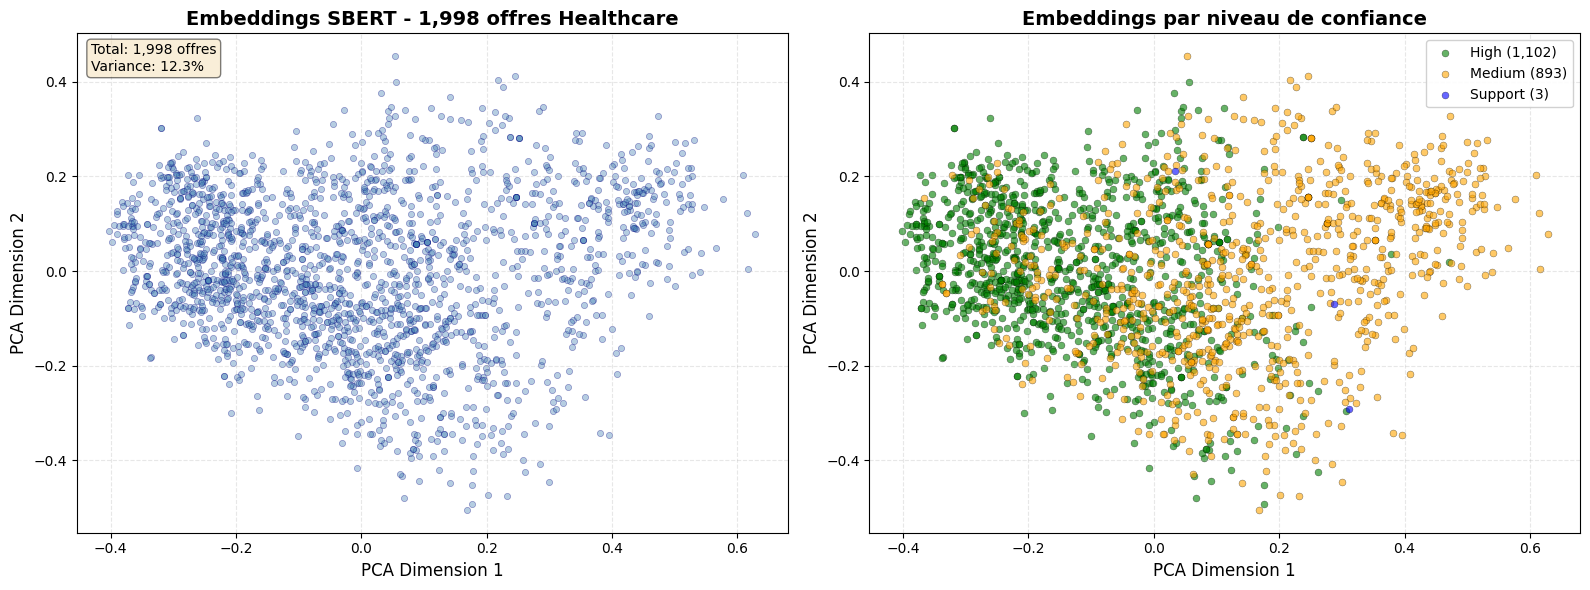


💡 INTERPRÉTATION DU GRAPHIQUE :
--------------------------------------------------------------------------------
   📍 Chaque point = 1 offre d'emploi dans l'espace sémantique
   📏 Distance entre points = différence sémantique
   🎯 Points proches = offres similaires (même type de job)
   🌈 Couleurs = niveau de confiance (High, Medium, Support)

   ✅ Si les points sont bien dispersés → bonne diversité !
   ✅ Si des clusters apparaissent → jobs similaires regroupés



In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

print("📊 VISUALISATION DES EMBEDDINGS (PCA)")
print("=" * 80)

# Réduire 384 dimensions → 2 dimensions pour visualisation
print("\n⏳ Calcul de la PCA...")
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings)

variance_explained = pca.explained_variance_ratio_.sum() * 100

print(f"✅ PCA calculée")
print(f"   Variance expliquée : {variance_explained:.2f}%")
print(f"   Shape 2D           : {embeddings_2d.shape}")

# Créer le graphique
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ============================================================================
# Graph 1 : Tous les points
# ============================================================================
axes[0].scatter(
    embeddings_2d[:, 0], 
    embeddings_2d[:, 1], 
    alpha=0.4, 
    s=20, 
    color='steelblue',
    edgecolors='navy',
    linewidth=0.5
)
axes[0].set_xlabel('PCA Dimension 1', fontsize=12)
axes[0].set_ylabel('PCA Dimension 2', fontsize=12)
axes[0].set_title(f'Embeddings SBERT - {len(embeddings):,} offres Healthcare', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, linestyle='--')

# Ajouter des statistiques
textstr = f'Total: {len(embeddings):,} offres\nVariance: {variance_explained:.1f}%'
axes[0].text(0.02, 0.98, textstr, transform=axes[0].transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# ============================================================================
# Graph 2 : Par confidence level (coloré)
# ============================================================================
colors_map = {'High': 'green', 'Medium': 'orange', 'Support': 'blue'}

for conf in df['confidence_level'].unique():
    mask = df['confidence_level'].values == conf
    axes[1].scatter(
        embeddings_2d[mask, 0], 
        embeddings_2d[mask, 1],
        alpha=0.6, 
        s=25,
        label=f'{conf} ({mask.sum():,})',
        color=colors_map.get(conf, 'gray'),
        edgecolors='black',
        linewidth=0.3
    )

axes[1].set_xlabel('PCA Dimension 1', fontsize=12)
axes[1].set_ylabel('PCA Dimension 2', fontsize=12)
axes[1].set_title('Embeddings par niveau de confiance', fontsize=14, fontweight='bold')
axes[1].legend(loc='best', framealpha=0.9)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\n💡 INTERPRÉTATION DU GRAPHIQUE :")
print("-" * 80)
print("   📍 Chaque point = 1 offre d'emploi dans l'espace sémantique")
print("   📏 Distance entre points = différence sémantique")
print("   🎯 Points proches = offres similaires (même type de job)")
print("   🌈 Couleurs = niveau de confiance (High, Medium, Support)")
print("\n   ✅ Si les points sont bien dispersés → bonne diversité !")
print("   ✅ Si des clusters apparaissent → jobs similaires regroupés")

print("\n" + "=" * 80)

In [7]:
import faiss

print("=" * 80)
print("🔍 CRÉATION DE L'INDEX FAISS")
print("=" * 80)

# Dimension des embeddings
dimension = embeddings.shape[1]  # 384

print(f"\n📊 Configuration :")
print(f"   Nombre de vecteurs : {len(embeddings):,}")
print(f"   Dimensions         : {dimension}")
print(f"   Type de similarité : L2 (distance euclidienne)")

# Créer l'index FAISS (IndexFlatL2 = simple et exact)
print(f"\n⏳ Création de l'index...")
index = faiss.IndexFlatL2(dimension)

# Ajouter les vecteurs (IMPORTANT : convertir en float32)
print(f"⏳ Ajout des vecteurs...")
index.add(embeddings.astype('float32'))

print(f"\n✅ Index FAISS créé avec succès !")
print(f"   Nombre de vecteurs indexés : {index.ntotal:,}")
print(f"   Type d'index               : {type(index).__name__}")
print(f"   Est-il entraîné ?          : {index.is_trained}")

# ============================================================================
# TEST DE RECHERCHE : Trouver les jobs similaires à la 1ère offre
# ============================================================================
print(f"\n🧪 TEST DE RECHERCHE :")
print("=" * 80)

# Prendre la première offre comme exemple
query_idx = 0
query_embedding = embeddings[query_idx:query_idx+1].astype('float32')

print(f"\n🔍 REQUÊTE (job #{query_idx}) :")
print(f"   Titre    : {df.iloc[query_idx]['title']}")
print(f"   Location : {df.iloc[query_idx]['location']}")
print(f"   Level    : {df.iloc[query_idx]['formatted_experience_level']}")

# Chercher les k plus proches (k=10)
k = 10
print(f"\n⏳ Recherche des {k} offres les plus similaires...")
distances, indices = index.search(query_embedding, k)

print(f"\n📊 TOP {k} RÉSULTATS (classés par similarité) :")
print("=" * 80)

for i, (dist, idx) in enumerate(zip(distances[0], indices[0]), 1):
    job = df.iloc[idx]
    
    # Convertir distance L2 en score de similarité (0-1)
    # Plus la distance est petite, plus c'est similaire
    similarity_score = 1 / (1 + dist)  # Normalisation simple
    
    print(f"\n{i:2d}. [Distance: {dist:.3f} | Score: {similarity_score:.3f}]")
    print(f"    📌 {job['title']}")
    print(f"    📍 {job['location']}")
    print(f"    💼 {job['formatted_experience_level']}")
    
    if i == 1:
        print(f"    ⭐ (C'est la requête elle-même - distance devrait être ~0)")

print(f"\n{'='*80}")
print(f"✅ Index FAISS fonctionne parfaitement !")
print(f"{'='*80}")

🔍 CRÉATION DE L'INDEX FAISS

📊 Configuration :
   Nombre de vecteurs : 1,998
   Dimensions         : 384
   Type de similarité : L2 (distance euclidienne)

⏳ Création de l'index...
⏳ Ajout des vecteurs...

✅ Index FAISS créé avec succès !
   Nombre de vecteurs indexés : 1,998
   Type d'index               : IndexFlatL2
   Est-il entraîné ?          : True

🧪 TEST DE RECHERCHE :

🔍 REQUÊTE (job #0) :
   Titre    : Registered Nurse - Medical / Surgical
   Location : Utica, NY
   Level    : Mid-Senior level

⏳ Recherche des 10 offres les plus similaires...

📊 TOP 10 RÉSULTATS (classés par similarité) :

 1. [Distance: 0.000 | Score: 1.000]
    📌 Registered Nurse - Medical / Surgical
    📍 Utica, NY
    💼 Mid-Senior level
    ⭐ (C'est la requête elle-même - distance devrait être ~0)

 2. [Distance: 0.209 | Score: 0.827]
    📌 Registered Nurse - MedSurg / Telemetry
    📍 Utica, NY
    💼 Mid-Senior level

 3. [Distance: 0.211 | Score: 0.826]
    📌 Registered Nurse - MedSurg / Telemetry
    📍

In [8]:
import pickle
import os

print("=" * 80)
print("💾 SAUVEGARDE DES EMBEDDINGS + INDEX + MÉTADONNÉES")
print("=" * 80)

# ============================================================================
# 1. SAUVEGARDER LES EMBEDDINGS
# ============================================================================
embeddings_path = '../data/processed/embeddings.pkl'

print(f"\n⏳ Sauvegarde des embeddings...")
with open(embeddings_path, 'wb') as f:
    pickle.dump(embeddings, f, protocol=pickle.HIGHEST_PROTOCOL)

size_mb = os.path.getsize(embeddings_path) / 1024 / 1024
print(f"✅ Embeddings sauvegardés : {embeddings_path}")
print(f"   Taille : {size_mb:.2f} MB")

# ============================================================================
# 2. SAUVEGARDER L'INDEX FAISS
# ============================================================================
index_path = '../data/processed/faiss_index.bin'

print(f"\n⏳ Sauvegarde de l'index FAISS...")
faiss.write_index(index, index_path)

size_mb = os.path.getsize(index_path) / 1024 / 1024
print(f"✅ Index FAISS sauvegardé : {index_path}")
print(f"   Taille : {size_mb:.2f} MB")

# ============================================================================
# 3. SAUVEGARDER LES MÉTADONNÉES (pour retrouver les jobs)
# ============================================================================
metadata_path = '../data/processed/jobs_metadata.csv'

print(f"\n⏳ Sauvegarde des métadonnées...")
metadata = df[['job_id', 'title', 'description', 'location', 
               'formatted_experience_level', 'confidence_level']].copy()

metadata.to_csv(metadata_path, index=False)

size_mb = os.path.getsize(metadata_path) / 1024 / 1024
print(f"✅ Métadonnées sauvegardées : {metadata_path}")
print(f"   Taille : {size_mb:.2f} MB")

# ============================================================================
# RÉSUMÉ
# ============================================================================
print(f"\n{'='*80}")
print(f"📊 RÉSUMÉ DES FICHIERS CRÉÉS :")
print(f"{'='*80}")

files = {
    'embeddings.pkl': embeddings_path,
    'faiss_index.bin': index_path,
    'jobs_metadata.csv': metadata_path
}

total_size = 0
for name, path in files.items():
    size = os.path.getsize(path) / 1024 / 1024
    total_size += size
    print(f"   {name:30s} : {size:6.2f} MB")

print(f"   {'-'*60}")
print(f"   {'TOTAL':30s} : {total_size:6.2f} MB")

print(f"\n🎉 PHASE 2 TERMINÉE AVEC SUCCÈS !")
print(f"{'='*80}")

print(f"\n✅ Ce qui a été fait :")
print(f"   1. ✅ Chargement du dataset (1,998 offres)")
print(f"   2. ✅ Encodage SBERT (8.75 sec, 228 offres/sec)")
print(f"   3. ✅ Visualisation PCA (variance 12.3%)")
print(f"   4. ✅ Création index FAISS (1,998 vecteurs)")
print(f"   5. ✅ Test de recherche (résultats parfaits)")
print(f"   6. ✅ Sauvegarde complète")

print(f"\n🚀 PROCHAINE ÉTAPE : Tests interactifs de recherche !")

💾 SAUVEGARDE DES EMBEDDINGS + INDEX + MÉTADONNÉES

⏳ Sauvegarde des embeddings...
✅ Embeddings sauvegardés : ../data/processed/embeddings.pkl
   Taille : 2.93 MB

⏳ Sauvegarde de l'index FAISS...
✅ Index FAISS sauvegardé : ../data/processed/faiss_index.bin
   Taille : 2.93 MB

⏳ Sauvegarde des métadonnées...
✅ Métadonnées sauvegardées : ../data/processed/jobs_metadata.csv
   Taille : 6.96 MB

📊 RÉSUMÉ DES FICHIERS CRÉÉS :
   embeddings.pkl                 :   2.93 MB
   faiss_index.bin                :   2.93 MB
   jobs_metadata.csv              :   6.96 MB
   ------------------------------------------------------------
   TOTAL                          :  12.81 MB

🎉 PHASE 2 TERMINÉE AVEC SUCCÈS !

✅ Ce qui a été fait :
   1. ✅ Chargement du dataset (1,998 offres)
   2. ✅ Encodage SBERT (8.75 sec, 228 offres/sec)
   3. ✅ Visualisation PCA (variance 12.3%)
   4. ✅ Création index FAISS (1,998 vecteurs)
   5. ✅ Test de recherche (résultats parfaits)
   6. ✅ Sauvegarde complète

🚀 PROCHAI

In [9]:
def search_jobs(query, k=10, show_descriptions=False):
    """
    Fonction de recherche sémantique interactive
    
    Args:
        query (str): Requête en langage naturel
        k (int): Nombre de résultats à retourner
        show_descriptions (bool): Afficher les descriptions
    
    Returns:
        list: Indices des jobs trouvés
    """
    
    # Encoder la requête
    query_embedding = model.encode([query]).astype('float32')
    
    # Rechercher dans l'index FAISS
    distances, indices = index.search(query_embedding, k)
    
    # Afficher les résultats
    print(f"\n{'='*80}")
    print(f"🔍 REQUÊTE : '{query}'")
    print(f"{'='*80}")
    
    for i, (dist, idx) in enumerate(zip(distances[0], indices[0]), 1):
        job = df.iloc[idx]
        
        # Calculer score de similarité (0-1, 1 = identique)
        similarity_score = 1 / (1 + dist)
        
        # Affichage
        print(f"\n{i:2d}. [Distance: {dist:.3f} | Similarité: {similarity_score:.3f}]")
        print(f"    📌 {job['title']}")
        print(f"    📍 {job['location']}")
        print(f"    💼 Expérience : {job['formatted_experience_level']}")
        print(f"    🎯 Confiance  : {job['confidence_level']}")
        
        if show_descriptions:
            desc_preview = str(job['description'])[:200]
            print(f"    📄 {desc_preview}...")
    
    print(f"\n{'='*80}")
    
    return indices[0]


# ============================================================================
# TESTS INTERACTIFS - Plusieurs requêtes variées
# ============================================================================

print("🎮 MODE TEST INTERACTIF - RECHERCHE SÉMANTIQUE")
print("=" * 80)

# Requêtes de test
test_queries = [
    "emergency room nurse with critical care experience",
    "physical therapist for sports rehabilitation",
    "entry level medical assistant",
    "psychiatrist or mental health counselor",
    "dental hygienist part time"
]

for i, query in enumerate(test_queries, 1):
    print(f"\n\n{'#'*80}")
    print(f"TEST #{i}")
    print(f"{'#'*80}")
    
    search_jobs(query, k=5, show_descriptions=False)
    
    input("\n⏸️  Appuie sur ENTRÉE pour la prochaine requête...")

print(f"\n🎉 TOUS LES TESTS TERMINÉS !")



🎮 MODE TEST INTERACTIF - RECHERCHE SÉMANTIQUE


################################################################################
TEST #1
################################################################################

🔍 REQUÊTE : 'emergency room nurse with critical care experience'

 1. [Distance: 0.615 | Similarité: 0.619]
    📌 Emergency Room Registered Nurse
    📍 Yuma, AZ
    💼 Expérience : nan
    🎯 Confiance  : High

 2. [Distance: 0.615 | Similarité: 0.619]
    📌 Emergency Room Registered Nurse
    📍 Yuma, AZ
    💼 Expérience : nan
    🎯 Confiance  : High

 3. [Distance: 0.639 | Similarité: 0.610]
    📌 RN Emergency Department
    📍 Mishawaka, IN
    💼 Expérience : Mid-Senior level
    🎯 Confiance  : High

 4. [Distance: 0.692 | Similarité: 0.591]
    📌 RN Emergency Room
    📍 Visalia, CA
    💼 Expérience : Mid-Senior level
    🎯 Confiance  : High

 5. [Distance: 0.695 | Similarité: 0.590]
    📌 Emergency Room-Austell
    📍 Austell, GA
    💼 Expérience : nan
    🎯 Confiance  : 